In [6]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
  raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

TORCH VERSION: 1.11.0+cu113


In [7]:
if torch.cuda.is_available():
  torch_device = 'cuda'
  float_dtype = np.float32 # single
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  torch_device = 'cpu'
  float_dtype = np.float64 # double
  torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy
array.

In [8]:
def torch_mod(x):
  return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
  return torch_mod(x+np.pi) - np.pi

Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy
array.

In [9]:
def grab(var):
  return var.detach().cpu().numpy()

The code below makes a live-updating plot during training.

In [10]:
from IPython.display import display
def init_live_plot(dpi=125, figsize=(8,4)):
  fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
  plt.xlim(0, N_era*N_epoch)
  plt.ylim(0, 1)
  ess_line = plt.plot([0],[0], alpha=0.5) # dummy
  plt.grid(False)
  plt.ylabel('ESS')
  ax_loss = ax_ess.twinx()
  loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
  plt.grid(False)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  display_id = display(fig, display_id=True)
  return dict(
    fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
    ess_line=ess_line, loss_line=loss_line,
    display_id=display_id
  )
def moving_average(x, window=10):
  if len(x) < window:
    return np.mean(x, keepdims=True)
  else:
    return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
  Y = np.array(history['ess'])
  Y = moving_average(Y, window=15)
  ess_line[0].set_ydata(Y)
  ess_line[0].set_xdata(np.arange(len(Y)))
  Y = history['loss']
  Y = moving_average(Y, window=15)
  loss_line[0].set_ydata(np.array(Y))
  loss_line[0].set_xdata(np.arange(len(Y)))
  ax_loss.relim()
  ax_loss.autoscale_view()
  fig.canvas.draw()
  display_id.update(fig) # need to force colab to update plot

Prior distribution

In [11]:
class Uniformdist:
  def __init__(self, loc, var):
    self.dist = torch.distributions.uniform.Uniform(
      torch.flatten(loc), torch.flatten(var))
    self.shape = loc.shape
  def log_prob(self, x):
    logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
    return torch.sum(logp, dim=1)
  def sample_n(self, batch_size):
    x = self.dist.sample((batch_size,))
    return x.reshape(batch_size, *self.shape)

The shape of loc and var determine the shape of samples drawn.

Design coupling layers

In [12]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
  x = prior.sample_n(batch_size)
  logq = prior.log_prob(x)
  for layer in coupling_layers:
    x, logJ = layer.forward(x)
    logq = logq - logJ
  return x, logq

In [13]:
class IsingAction:
  def __init__(self, K):
    self.K = K
    #self.lam = lam
  def __call__(self, cfgs):
    action_density = 0
    
    Nd = len(cfgs.shape)-1
    dims = range(1,Nd+1)
    for mu in dims:
      action_density -= self.K*cfgs*torch.roll(cfgs, 1, mu)
    return torch.sum(action_density, dim=tuple(dims))


In [15]:
lattice_shape = (8,8)

Prior distributions

In [17]:
prior = Uniformdist(-1*torch.ones(lattice_shape), torch.ones(lattice_shape))

z.shape = (1024, 8, 8)


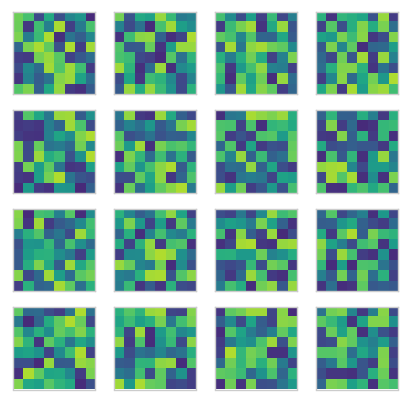

In [18]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
  for j in range(4):
    ind = i*4 + j
    ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
plt.show()

In [19]:
def make_checker_mask(shape, parity):
  checker = torch.ones(shape, dtype=torch.uint8) - parity
  checker[::2, ::2] = parity
  checker[1::2, 1::2] = parity
  return checker.to(torch_device)
print("For example this is the mask for an 8x8 configuration:\n",
make_checker_mask((8,8), 0))

For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


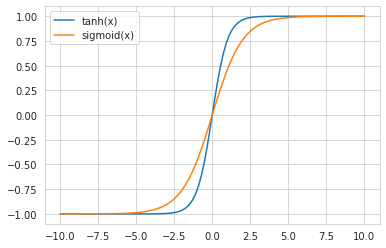

In [20]:
x=np.linspace(-10,10,100)
y=np.tanh(x)
y1=1/(1+np.exp(-x))*2-1
plt.plot(x,y,label='tanh(x)')
plt.plot(x,y1,label='sigmoid(x)')
plt.legend(loc="upper left")
plt.show()

In [21]:
class AffineCoupling(torch.nn.Module):
  def __init__(self, net, *, mask_shape, mask_parity, final_layer):
    super().__init__()
    self.mask = make_checker_mask(mask_shape, mask_parity)
    self.net = net
    self.final_layer = final_layer
  def forward(self, x):
    x_frozen = self.mask * x
    x_active = (1 - self.mask) * x
    net_out = self.net(x_frozen.unsqueeze(1))
    s, t = net_out[:,0], net_out[:,1]
    axes = range(1,len(s.size()))
    fx = x
    logJ = 0
    
    if (self.final_layer == True):
      fx = (1 - self.mask) * torch.tanh(t + x * torch.exp(s)) + x_frozen
      logJ = torch.sum((1 - self.mask) * (s - 2*torch.log(torch.cosh(t + x * torch.exp(s)))), dim=tuple(axes))
      
    else:
      fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
      logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
      
    return fx, logJ
  def reverse(self, fx):
    fx_frozen = self.mask * fx 
    fx_active = (1 - self.mask) * fx
    net_out = self.net(fx_frozen.unsqueeze(1))
    s, t = net_out[:,0], net_out[:,1]
    axes = range(1,len(s.size()))
    if (self.final_layer):
      
      x = (1 - self.mask) * (torch.atanh(fx) - t) * torch.exp(-s) + fx_frozen
      logJ = torch.sum((1 - self.mask)*(-s + 2*torch.log(torch.cosh(t + x * torch.exp(s)))), dim=tuple(axes))
    else:
      x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
      logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
    return x, logJ


In [22]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
  sizes = [in_channels] + hidden_sizes + [out_channels]
  assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
  assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
  padding_size = (kernel_size // 2)
  net = []
  for i in range(len(sizes) - 1):
    net.append(torch.nn.Conv2d(
      sizes[i], sizes[i+1], kernel_size, padding=padding_size,
      stride=1, padding_mode='circular'))
    if i != len(sizes) - 2:
      net.append(torch.nn.LeakyReLU())
    else:
      if use_final_tanh:
        net.append(torch.nn.Tanh())
  return torch.nn.Sequential(*net)

Assembling the model

In [23]:
from typing_extensions import Final
def make_ising_affine_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
  layers = []
  for i in range(n_layers):
    parity = i % 2
    if i == n_layers-1 or i == n_layers-2:
      final_layer = True
    else:
      final_layer = False
    net = make_conv_net(
      in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
      kernel_size=kernel_size, use_final_tanh=True)
    coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity, final_layer=final_layer)
    layers.append(coupling)
  return torch.nn.ModuleList(layers)

In [24]:
L = 8
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
lattice_shape = (L,L)
layers = make_ising_affine_layers(
  lattice_shape=lattice_shape, n_layers=n_layers,
  hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

Training the model

In [25]:
def calc_dkl(logp, logq):
  return (logq - logp).mean() # reverse KL, assuming samples from 

In [26]:
def train_step(model, action, loss_fn, optimizer, metrics):
  layers, prior = model['layers'], model['prior']
  optimizer.zero_grad()
  x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
  logp = -action(x)
  #print(logp)
  loss = calc_dkl(logp, logq)
  loss.backward()
  optimizer.step()
  metrics['loss'].append(grab(loss))
  metrics['logp'].append(grab(logp))
  metrics['logq'].append(grab(logq))
  metrics['ess'].append(grab( compute_ess(logp, logq) ))

Telemetry

In [27]:
def compute_ess(logp, logq):
  logw = logp - logq
  log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
  ess_per_cfg = torch.exp(log_ess) / len(logw)
  return ess_per_cfg

In [28]:
def print_metrics(history, avg_last_N_epochs):
  print(f'== Era {era} | Epoch {epoch} metrics ==')
  for key, val in history.items():
    avgd = np.mean(val[-avg_last_N_epochs:])
    print(f'\t{key} {avgd:g}')

The training

In [29]:
use_trained = True

In [30]:
N_era = 12
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1
history = {
  'loss' : [],
  'logp' : [],
  'logq' : [],
  'ess' : []
}


In [31]:
K_vals = np.concatenate((np.linspace(0.1, 0.43 , 5),np.linspace(0.46,1.5,5)),axis=0 )
print (K_vals)

[0.1    0.1825 0.265  0.3475 0.43   0.46   0.72   0.98   1.24   1.5   ]


In [32]:
if not use_trained:
  for K in K_vals:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()
    
    ising_action = IsingAction(K = K)
    prior = Uniformdist(-1*torch.ones(lattice_shape), torch.ones(lattice_shape))
    layers = make_ising_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers,
      hidden_sizes=hidden_sizes, kernel_size=kernel_size)
    model = {'layers': layers, 'prior': prior}
    
    base_lr = .01
    optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

    for era in range(N_era):
      for epoch in range(N_epoch):
        train_step(model, ising_action, calc_dkl, optimizer, history)
        if epoch % print_freq == 0:
          print_metrics(history, avg_last_N_epochs=print_freq)
        if epoch % plot_freq == 0:
          update_plots(history, **live_plot)
    torch.save(model['layers'].state_dict(), f'K_{K}.pt')
else:
  print('Training skipped, using pretrained models!!')

Training skipped, using pretrained models!!


In [33]:
def magnetization(x):
  M = np.zeros(len(x))
  for i in range(len(M)):
    M[i] = np.abs(np.mean(x[i]))
  return np.mean(M)

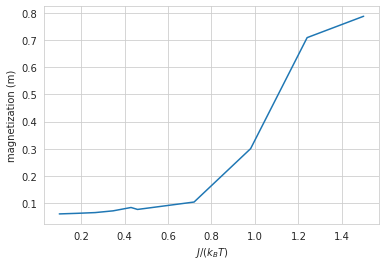

In [37]:
m = []
for K in K_vals:
  ising_action = IsingAction(K = K)
  prior = Uniformdist(-1*torch.ones(lattice_shape), torch.ones(lattice_shape))
  layers = make_ising_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers,
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
  model = {'layers': layers, 'prior': prior}
  
  model['layers'].load_state_dict(torch.load(f'K_{K}.pt'))
  torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
  x = grab(torch_x)
  
  m.append(magnetization(x))

plt.xlabel(r'$J/(k_{B}T)$')
plt.ylabel('magnetization (m)')
plt.plot(K_vals, m)

In [35]:
'''
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
  for j in range(4):
    ind = i*4 + j
    ax[i,j].imshow(x[ind], vmin=-1, vmax=1, cmap='viridis')
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
plt.show()
#print(x)
'''

"\ntorch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)\nx = grab(torch_x)\nfig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))\nfor i in range(4):\n  for j in range(4):\n    ind = i*4 + j\n    ax[i,j].imshow(x[ind], vmin=-1, vmax=1, cmap='viridis')\n    ax[i,j].axes.xaxis.set_visible(False)\n    ax[i,j].axes.yaxis.set_visible(False)\nplt.show()\n#print(x)\n"

In [36]:
'''
S_eff = -grab(torch_logq)
S = grab(ising_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[0, 80], [-50, 50]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(30, 70, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()
'''

"\nS_eff = -grab(torch_logq)\nS = grab(ising_action(torch_x))\nfit_b = np.mean(S) - np.mean(S_eff)\nprint(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')\nfig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))\nax.hist2d(S_eff, S, bins=20, range=[[0, 80], [-50, 50]])\nax.set_xlabel(r'$S_{\\mathrm{eff}} = -\\log~q(x)$')\nax.set_ylabel(r'$S(x)$')\nax.set_aspect('equal')\nxs = np.linspace(30, 70, num=4, endpoint=True)\nax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')\nplt.legend(prop={'size': 6})\nplt.show()\n"